# Eigenface


In [297]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob # 文件系统操作
import mask

dataset = "./att_faces"

In [298]:
#function to plot the images
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [299]:
total_images = 0
image_shape = None

In [300]:
# show images
for image in glob.glob(dataset + '/**', recursive=True):
    if image[-3:] == 'pgm' or image[-3:] == 'jpg':
        total_images += 1

In [301]:
total_images

400

## 读取图像并显示

In [271]:
image_shape = (112, 92)
all_images = np.zeros((total_images, image_shape[0], image_shape[1]), dtype=np.float64)
names = list()
i = 0
for folder in glob.glob(dataset + '/*'):
    # print(folder)
    for _ in range(10):
        names.append(folder[-3:].replace('/', ''))
    for image in glob.glob(folder + '/*'): #iterate through each folder (class)
        read_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE) #read the image in grayscale
        resized_image = cv2.resize(read_image, (image_shape[1], image_shape[0])) #cv2.resize resizes an image into (# column x # height)
        all_images[i] = np.array(resized_image)
        i += 1

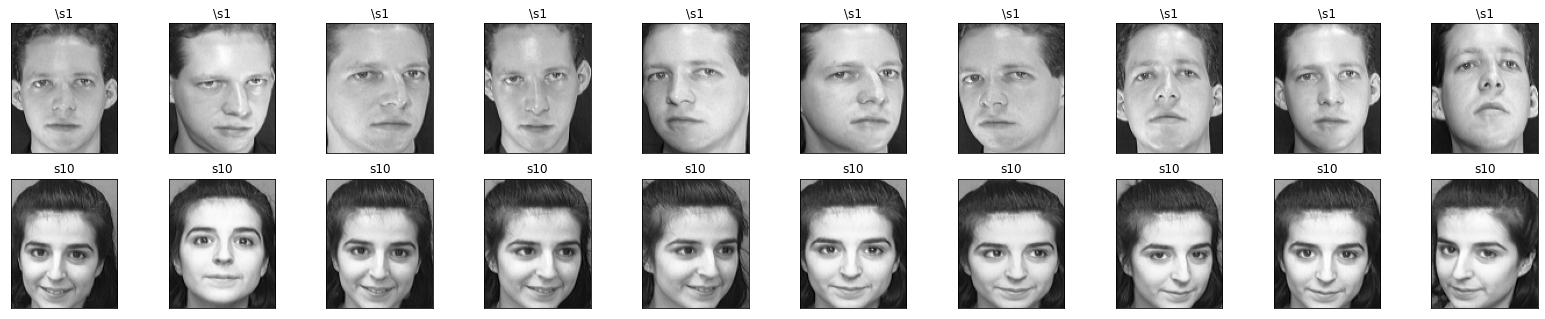

In [272]:
plot_portraits(all_images, names, image_shape[0], image_shape[1], 2, 10)

## 平均人脸

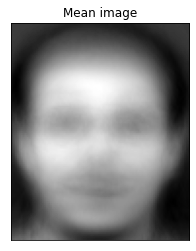

In [236]:
# convert to vector
A = np.reshape(all_images, (total_images, image_shape[0]*image_shape[1]))
mean_vector = np.sum(A, axis=0, dtype=np.float64) / total_images
mean_matrix = np.tile(mean_vector, (total_images, 1))  # repeat mean_vector total_images in axis=0, and 1 in axis=1 
plt.imshow(np.resize(mean_vector, (image_shape[0], image_shape[1])), cmap='gray')
plt.title("Mean image")
plt.xticks(())
plt.yticks(())
plt.show()


## PCA 

* PCA是对vector的covariance matrix求特征值和特征向量。
* 在求协方差矩阵的时候，将vector减去其平均值，是的其均值变成0，则协方差矩阵的求解方式可以简化成如下所示：
$$
cov = \frac{X^TX}{n-1}
$$
* 但是如果feature数量太多，可以将公式变成$XX^T$，在求出这个矩阵的特征值和特征向量之后，对其特征向量左乘$X^T$


In [237]:
A_submean = A - mean_matrix  # make the mean = 0
cov = A_submean.dot(np.transpose(A_submean)) / (total_images - 1)  # covariance matrix
lamdas, lamda_vectors = np.linalg.eig(cov)
index = lamdas.argsort()[::-1]  # argsort default ascending, so change to descending
eigenvalues = lamdas[index]
lamda_vectors = lamda_vectors[:, index] # each column is an eigenvector of C where C = (A_tilde)(A_tilde.T)
eigenvectors = A_submean.T @ lamda_vectors # each column is an eigenvector of C where C = (A_tilde.T)(A_tilde)

## 显示训练好的特征脸

In [239]:
#from sklearn import preprocessing
eigenvectors.shape

(10304, 400)

In [240]:
# L2 normalization
eigen = eigenvectors * eigenvectors
eigen_sum = np.sum(eigen, axis=0)
eigen_square_sum = np.tile(eigen_sum, (eigenvectors.shape[0], 1))
# eigen_square_sum
eigenfaces = eigen / eigen_square_sum
eigenfaces = eigenfaces.T
eigenfaces

array([[4.51596174e-06, 4.46378077e-06, 4.59032419e-06, ...,
        4.95623838e-05, 4.08443921e-05, 5.39460030e-05],
       [2.15653649e-04, 2.13567193e-04, 2.14091453e-04, ...,
        1.11535523e-04, 9.41034921e-05, 7.77734348e-05],
       [3.97184497e-04, 4.00368112e-04, 3.93566771e-04, ...,
        2.00609915e-04, 2.07197584e-04, 2.21262492e-04],
       ...,
       [5.25021116e-05, 3.16425469e-07, 7.56833401e-06, ...,
        2.09708374e-05, 2.12204261e-08, 4.56396109e-04],
       [3.90644671e-06, 6.01250477e-06, 1.26083019e-07, ...,
        9.16269183e-05, 9.95506994e-05, 1.11717809e-04],
       [1.39409847e-05, 2.06227585e-06, 8.24910340e-08, ...,
        2.06227585e-06, 4.64012066e-08, 2.99755017e-05]])

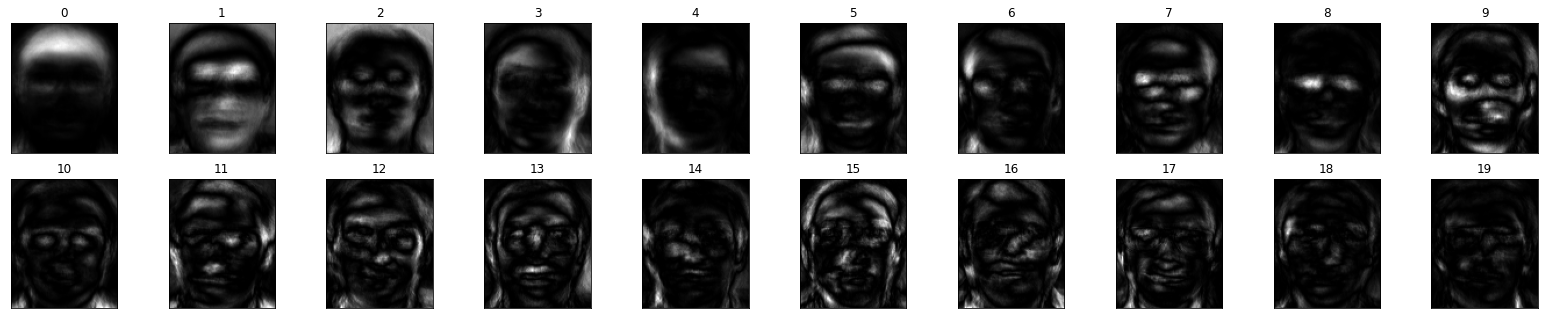

In [241]:
eigenface_labels = [x for x in range(eigenfaces.shape[0])] #list containing values from 1 to number of eigenfaces
plot_portraits(eigenfaces, eigenface_labels , 112,92, 2, 10)

(400, 10304)

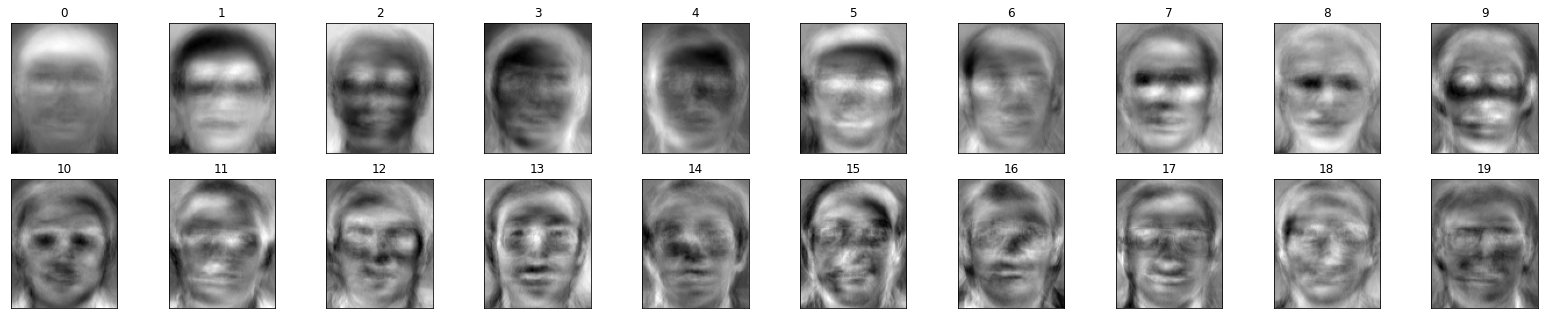

In [242]:
from sklearn import preprocessing
eigenfaces = preprocessing.normalize(eigenvectors, axis=0).T #normalize only accepts matrix with n_samples, n_feature. Hence the transpose.
eigenface_labels = [x for x in range(eigenfaces.shape[0])] #list containing values from 1 to number of eigenfaces
plot_portraits(eigenfaces, eigenface_labels , 112,92, 2, 10) 
eigenfaces.shape

# 将前十张特征脸显示在一张图中

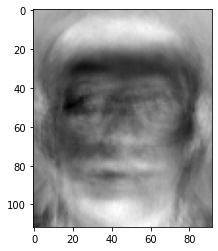

In [243]:
pc10 = np.sum(eigenfaces[0:10, :], axis=0) / 10
plt.imshow(np.reshape(pc10, (image_shape[0], image_shape[1])), cmap='gray')
plt.show()

# 作业：训练
* 按照1:1的比例将数据集划分成为训练集和测试集

In [244]:
# 随机选取训练集和测试集
rand_index = np.arange(10)
np.random.shuffle(rand_index)

train_index = rand_index[0:5]
test_index = rand_index[5:10]

train = 0
test = 0

train_num = total_images//2
test_num = total_images//2

train_images = np.zeros((total_images//2, image_shape[0]*image_shape[1]), dtype=np.float64)
test_images = np.zeros((total_images//2, image_shape[0]*image_shape[1]), dtype=np.float64)

for i in range(40):
    for j in range(10):
        if j in train_index:
            train_images[train] = A[i * 10 + j]
            train += 1
        elif j in test_index:
            test_images[test] = A[i * 10 + j]
            test += 1

train_images.shape


(200, 10304)

array([6, 0, 3, 1, 7])

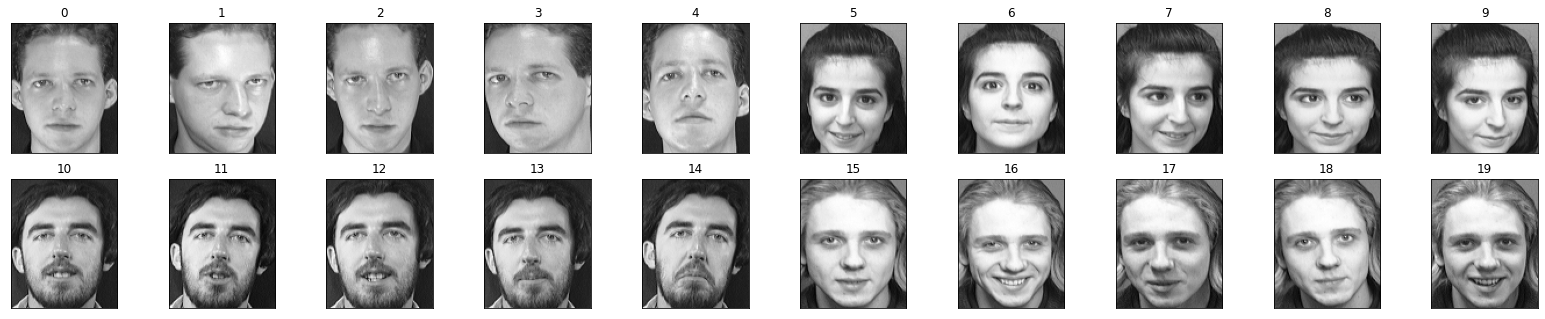

In [250]:
plot_portraits(train_images, np.arange(200), image_shape[0], image_shape[1], 2, 10)
train_index

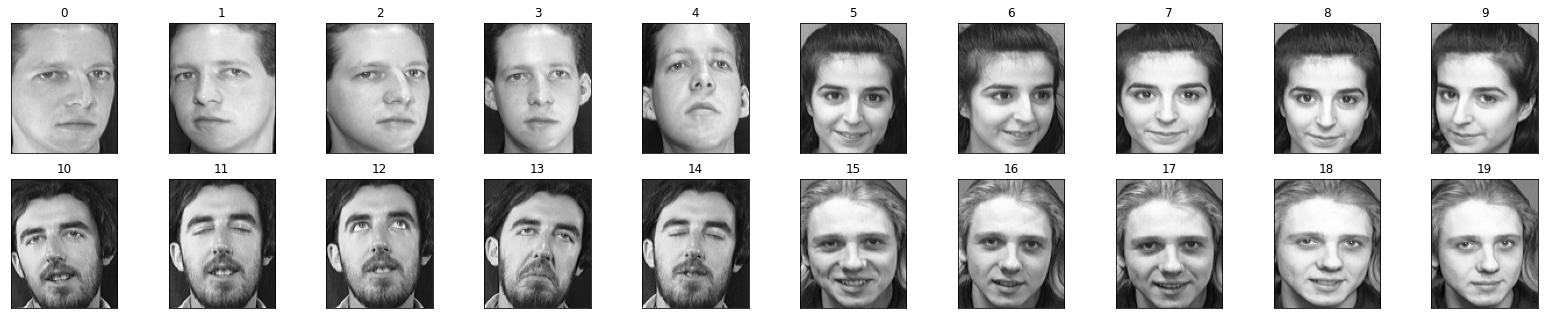

In [246]:
plot_portraits(test_images, np.arange(200), image_shape[0], image_shape[1], 2, 10)

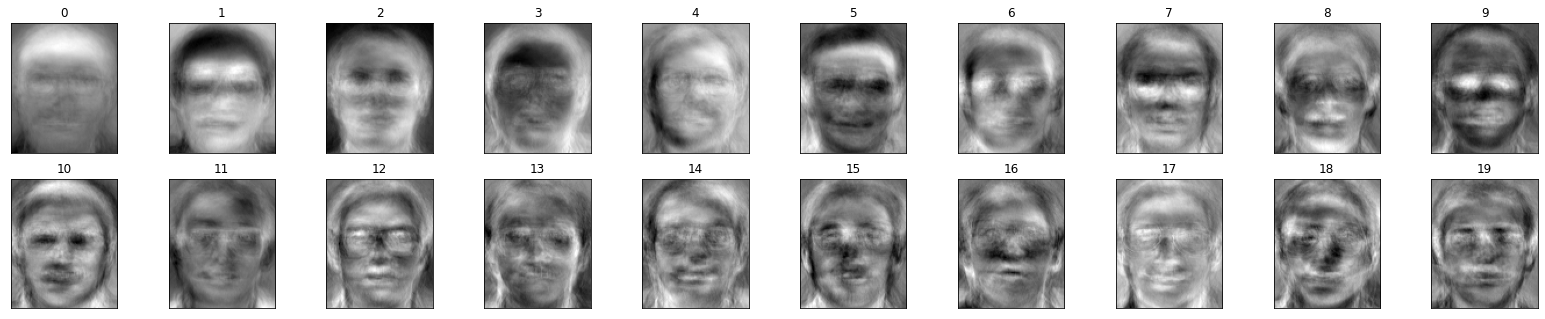

In [247]:



def PCA(cov, A_submean):
    lamdas, lamda_vectors = np.linalg.eig(cov)
    index = lamdas.argsort()[::-1]  # argsort default ascending, so change to descending
    eigenvalues = lamdas[index]
    lamda_vectors = lamda_vectors[:, index] # each column is an eigenvector of C where C = (A_tilde)(A_tilde.T)
    eigenvectors = A_submean.T @ lamda_vectors # each column is an eigenvector of C where C = (A_tilde.T)(A_tilde)
    return eigenvalues, eigenvectors

mean_vector = np.sum(train_images, axis=0, dtype=np.float64) / train_num
mean_matrix = np.tile(mean_vector, (train_num, 1))
A_submean = train_images - mean_matrix  # make the mean = 0
cov = A_submean.dot(np.transpose(A_submean)) / (train_num - 1)  # covariance matrix

eigenvalues, eigenvectors = PCA(cov, A_submean)

eigenfaces = preprocessing.normalize(eigenvectors, axis=0).T #normalize only accepts matrix with n_samples, n_feature. Hence the transpose.
eigenface_labels = [x for x in range(eigenfaces.shape[0])] #list containing values from 1 to number of eigenfaces
plot_portraits(eigenfaces, eigenface_labels , 112,92, 2, 10) 

## 识别
* 按照1:1的比例将数据集划分成为训练集和测试集
* 识别：选取distance最小的
$$
f is the test input \\
y_t = Af \\
distance(y_t, Af_{alltest})
$$


In [248]:
pc_num = 25  # number of eigenfaces

smallest_distance = None
choice = None
right = 0

# # subspace_test = eigenfaces[:pc_num].dot(test_images.T)
# # subspace_test.shape
# # subspace_train = eigenfaces[:pc_num].dot(train_images.T)
# # subspace_train.shape
# # for i in range(test_images.shape[0]):
# #     subspace_test = eigenfaces[:pc_num].dot(test_images[i])
# #     for j in range(train_images.shape[0]):
# #         subspace_train = eigenfaces[:pc_num].dot(train_images[j])
# #         diff = subspace_test - subspace_train
# #         # distance = np.sqrt(diff.dot(diff))

# #         if distance < smallest_distance:
# #             smallest_distance = distance
# #             choice = j

# #     # judge if the choice right
# #     if i%5 == j%5:
# #         right += 1

subspace_test = eigenfaces[:pc_num].dot(test_images.T)
subspace_train = eigenfaces[:pc_num].dot(train_images.T)
for i in range(test_num):
    smallest_distance = None
    for j in range(train_num):
        diff = subspace_test[:, i] - subspace_train[:, j]
        # print(diff.shape)
        distance = diff.dot(diff)
        if smallest_distance == None:
            smallest_distance = distance
            choice = j
        if distance < smallest_distance:
            smallest_distance = distance
            choice = j

    # judge if the choice right
    if i//5 == choice//5:
        right += 1


acc = right/test_images.shape[0]
acc


0.93

In [249]:
pc_num = 25  # number of eigenfaces

smallest_distance = None
choice = None
right = 0

subspace_test = eigenfaces[:pc_num].dot(test_images.T)
subspace_train = eigenfaces[:pc_num].dot(train_images.T)
for i in range(test_num):
    test = np.tile(subspace_test[:, i], (train_images.shape[0],1)).T
    # print(test.shape)
    diff = subspace_train - test
    distance = np.diagonal(diff.T.dot(diff))
    choice = np.argmin(distance)
    # judge if the choice right
    if i//5 == choice//5:
        right += 1

right
right/test_num

0.93

In [ ]:
# 显示人脸图片

## 重构
* 在识别的基础上，对$y_t$左乘$A^T$

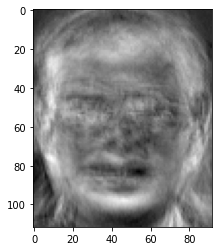

In [253]:
reconstruction_image = test_images[122]
temp = eigenfaces[:pc_num].dot(reconstruction_image)
reconstructed_image = eigenfaces[:pc_num].T.dot(temp)

plt.imshow(np.reshape(reconstructed_image, (image_shape[0], image_shape[1])), cmap='gray')
# plt.imshow(np.reshape(reconstruction_image, (image_shape[0], image_shape[1])), cmap='gray')
